In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, regularizers,models, callbacks, optimizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model

import cv2  
import numpy as np
import os

path_0 = './0_round'
path_1 = './1_square'
path_2 = './2_heart'
path_3 = './3_long'
path_4 = './4_oval'
path_5 = './5_triangle'

In [7]:
# 清除当前会话中的模型
tf.keras.backend.clear_session()

features, labels = [], []

# 定义一个函数来读取图像并添加到features和labels
def read_images_from_path(path, label):
    for file_name in os.listdir(path):
        if file_name.endswith('.jpg'):
            img_path = os.path.join(path, file_name)
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)  # 读取彩色图像
            if img is not None:
                img = cv2.resize(img, (150, 150))
                features.append(img)
                labels.append(label)

# 读取所有类别的图像
read_images_from_path(path_0, 0)
read_images_from_path(path_1, 1)
read_images_from_path(path_2, 2)
read_images_from_path(path_3, 3)
read_images_from_path(path_4, 4)
read_images_from_path(path_5, 5)

# 转换列表为numpy数组并归一化图像
features = np.asarray(features, np.float32) / 255.0
labels = np.asarray(labels, np.int32)

# 重新调整图像的形状以匹配神经网络的输入形状 (4D)
train_images = features.reshape((-1, 150, 150, 3))  # 彩色图像有3个通道
train_labels = labels

# 分割训练集和验证集
x_train, x_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=6)

# 将标签转换为one-hot编码
y_train = to_categorical(y_train, num_classes=6)
y_val = to_categorical(y_val, num_classes=6)

print(x_train.shape)
print(x_val.shape)

(241, 150, 150, 3)
(61, 150, 150, 3)


In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model

# 清除当前会话中的模型
tf.keras.backend.clear_session()

# 定义图像数据生成器用于数据增强
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255)

# 假设 x_train, y_train, x_val, y_val 已经准备好
# 这里用 train_datagen.flow() 和 val_datagen.flow() 来生成数据

# 定义一个输入层，将彩色图像输入
input_tensor = layers.Input(shape=(150, 150, 3))  # 彩色图像有3个通道

# 使用 ResNet50 作为基础模型
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)

# 冻结基础模型的所有层
for layer in base_model.layers:
    layer.trainable = False

# 添加自定义顶层
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(6, activation='softmax')(x)

# 创建最终模型
model = Model(inputs=input_tensor, outputs=predictions)

# 查看模型层次
model.summary()

# 编译模型
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 设置回调函数
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# 训练模型
history = model.fit(
    train_datagen.flow(x_train, y_train, batch_size=32),
    epochs=100,
    validation_data=val_datagen.flow(x_val, y_val),
    callbacks=[early_stopping, reduce_lr]
)

# 解冻部分基础模型层，进行微调
for layer in base_model.layers[-30:]:  # 解冻最后30层
    layer.trainable = True

# 重新编译模型（在较低学习率下微调）
model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 继续训练模型（微调）
history_fine_tune = model.fit(
    train_datagen.flow(x_train, y_train, batch_size=32),
    epochs=50,
    validation_data=val_datagen.flow(x_val, y_val),
    callbacks=[early_stopping, reduce_lr]
)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']         

In [3]:
#載入舊模型
import numpy as np
import cv2
from tensorflow.keras.models import load_model
load_model_path='C:/DL_model/best_model.h5'
model = load_model(load_model_path)


ValueError: in user code:

    File "c:\Users\User\anaconda3\envs\DL_39\lib\site-packages\keras\engine\training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\User\anaconda3\envs\DL_39\lib\site-packages\keras\engine\training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\User\anaconda3\envs\DL_39\lib\site-packages\keras\engine\training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\User\anaconda3\envs\DL_39\lib\site-packages\keras\engine\training.py", line 2111, in predict_step
        return self(x, training=False)
    File "c:\Users\User\anaconda3\envs\DL_39\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\User\anaconda3\envs\DL_39\lib\site-packages\keras\engine\input_spec.py", line 280, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential' (type Sequential).
    
    Input 0 of layer "conv2d" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (None, 150, 150, 3)
    
    Call arguments received by layer 'sequential' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 150, 150, 3), dtype=float32)
      • training=False
      • mask=None


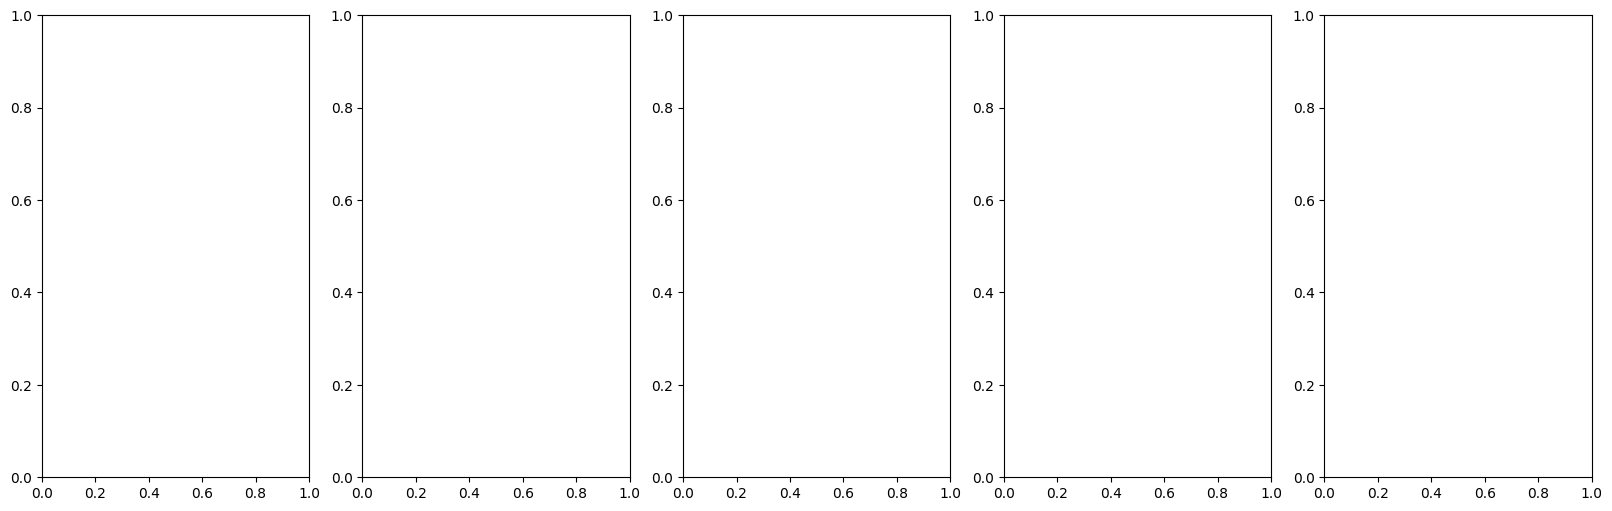

In [4]:
import matplotlib.pyplot as plt

# Assuming 'model' is your trained model

# Function to predict and plot images
def predict_and_plot(image_path, model, ax):
    # Load and preprocess the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img_resized = cv2.resize(img, (150, 150))
    img_resized = img_resized / 255.0
    img_resized = np.expand_dims(img_resized, axis=0)  # Add batch dimension
    
    # Predict using the model
    prediction = model.predict(img_resized)
    class_label = np.argmax(prediction)
    prob_distribution = prediction.squeeze()
    prob_distribution_str = '\n'.join([f'Class {i}: {prob:.2f}' for i, prob in enumerate(prob_distribution)])
    # Plot the image with predicted label
    ax.imshow(img)
    ax.set_title(f'Predicted Class: {class_label}')
    ax.axis('off')
    ax.text(10, 20, f'Prob:\n{prob_distribution_str}', fontsize=20, ha='left', va='top', color='green')

# List of image paths
image_paths = ['./test_data/square.jpg', './test_data/heart.jpg', './test_data/long.jpg',
               './test_data/round.jpg', './test_data/trangle.jpg']

# Create subplots for each image
fig, axes = plt.subplots(1, 5, figsize=(20, 6))

# Iterate over each image path and plot
for i, image_path in enumerate(image_paths):
    predict_and_plot(image_path, model, axes[i])

plt.tight_layout()
plt.show()
